# Nakagami V1 - FNN

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]= "2"

import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.special import gamma, gammaincinv

np.random.seed(1234) # The random seed could be different from what we used for the paper.

2023-12-10 01:54:02.015105: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 01:54:02.058487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 01:54:02.931716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Core functions

In [2]:
class NakagamiV1:
    def __init__(self, m:int=1, eta:float=1, d_0:int=100, d:int=200, alpha:int=2, 
                 QAM:np.ndarray=np.asarray([-3 - 3j, -3 - 1j, -3 + 1j, -3 + 3j, -1 - 3j, -1 - 1j, -1 + 1j, -1 + 3j,
                        1 - 3j, 1 - 1j, 1 + 1j, 1 + 3j, 3 - 3j, 3 - 1j, 3 + 1j, 3 + 3j], dtype=np.complex64)):
        self.m = m
        self.eta = eta
        self.d_0 = d_0
        self.d = d
        self.alpha = alpha
        self.QAM = QAM
    
    # Will use this to notify whether it is positive, negative or zero
    def sign_checker(self, numeric_value):
        if numeric_value > 0 :
            return 1
        
        elif numeric_value == 0:
            return 0
        
        elif numeric_value < 0:
            return -1
    

    def sign_checker_array(self, target_array):
        # Use a list comprehension to apply the sign_checker function to each element in target_array
        sign_array = np.array([self.sign_checker(x) for x in target_array])
        
        return sign_array
    
    def generate(self, number:int=10000, use_balanced_r:bool=False, balanced_r_real=None, balanced_r_imaginary=None):
        r_real = np.random.uniform(size=number)
        r_imaginary = np.random.uniform(size=number)
        
        # randomly chose one of the signals : Its QAM 16, but start without negative values for the calculation
        labels_index = np.random.choice(len(self.QAM), number)
        Pt = self.QAM[labels_index]

        Pr_d = Pt * self.eta * np.power((self.d_0/self.d), self.alpha)
        
        RHS_real = gammaincinv(self.m, gamma(self.m)*r_real) / self.m
        RHS_imaginary = gammaincinv(self.m, gamma(self.m)*r_imaginary) / self.m
        
        data_real = np.real(Pr_d) * RHS_real
        data_imaginary = np.imag(Pr_d) * RHS_imaginary
        
        sign_data_real = self.sign_checker_array(data_real)
        sign_data_imaginary = self.sign_checker_array(data_imaginary)
        
        # Without Noise
        nakagami_real = sign_data_real * np.sqrt(abs(data_real)) 
        nakagami_imaginary = sign_data_imaginary * np.sqrt(abs(data_imaginary))
        
        # without 1j
        nakagami_complex = np.hstack([nakagami_real.reshape(number, 1), nakagami_imaginary.reshape(number, 1)])
        
        # condition = np.hstack([np.real(Pt), np.imag(Pt), np.asarray([RHS_real]), np.asarray([RHS_imaginary])])
        condition = np.hstack([np.real(Pt).reshape(number, 1)/3, np.imag(Pt).reshape(number, 1)/3, 
                               r_real.reshape(number, 1), r_imaginary.reshape(number, 1)])
        
        return nakagami_complex, condition, np.expand_dims(labels_index, axis=1)
        
        
        

In [3]:
class NakagamiV1Evaluator(NakagamiV1):
    def __init__(self):
        # Refer NakagamiV2
        super().__init__()
    
    def validate_mean(self):
        
        list_ideal_mean = list()
        
        for idx in range(len(self.QAM)):
            Pt = self.QAM[idx]
            
            Pr_d_real = np.real(Pt) * self.eta * (self.d_0/self.d)**self.alpha
            Pr_d_imaginary = np.imag(Pt) * self.eta * (self.d_0/self.d)**self.alpha
            
            ## memorize whether it is negative, zero, or positive : -1 or 0 or 1 
            ## because np.sqrt(netative_value) not working - but the abs values are the same
            sign_Pr_d_real = self.sign_checker(Pr_d_real)
            sign_Pr_d_imaginary = self.sign_checker(Pr_d_imaginary)
            
            ideal_mean_real = (gamma(self.m + 1/2)/gamma(self.m)) * (sign_Pr_d_real*np.sqrt(abs(Pr_d_real)/self.m))
            ideal_mean_imaginary = (gamma(self.m + 1/2)/gamma(self.m)) * (sign_Pr_d_imaginary*np.sqrt(abs(Pr_d_imaginary)/self.m))

            list_ideal_mean.append(np.hstack((ideal_mean_real, ideal_mean_imaginary)))
            
        return np.asarray(list_ideal_mean)
    
    def validate_var(self):
        
        list_ideal_var = list()
        
        for idx in range(len(self.QAM)):

            Pt = self.QAM[idx]
            Pr_d = Pt * self.eta * (self.d_0/self.d)**self.alpha

            RHS = (1 - (1/self.m) * np.power((gamma(self.m + 1/2)/gamma(self.m)), 2))
            
            ideal_var_real = abs(np.real(Pr_d)) * RHS
            ideal_var_imaginary = abs(np.imag(Pr_d)) * RHS
            
            list_ideal_var.append(np.hstack((ideal_var_real, ideal_var_imaginary)))
        
        return np.asarray(list_ideal_var)
            
        

## Genuine Data Generation

In [4]:
con = NakagamiV1()

In [5]:
data_for_ai, condition_for_ai, indices_array = con.generate(number=1080000)

## Genuine Data Evaluation

In [6]:
df_genuine = pd.DataFrame(data=np.hstack((data_for_ai, indices_array)), columns=['real', 'imaginary', 'QAM'])
df_genuine

,real,imaginary,QAM
0,0.230542,-0.226998,9.0
1,-0.854319,0.679017,3.0
2,0.379397,-0.288766,9.0
3,1.074286,0.495384,14.0
4,0.615227,0.609021,10.0
...,...,...,...
1079995,-0.306809,0.688995,3.0
1079996,-0.435399,-0.978913,4.0
1079997,1.378059,-1.304323,12.0
1079998,0.517224,-0.997700,8.0


### Calculate the Ideal mean and var of the Nakagami

In [7]:
df_ideal_mean = pd.DataFrame(data=NakagamiV1Evaluator().validate_mean(), columns=['ideal_real', 'ideal_imaginary'])
df_ideal_mean

,ideal_real,ideal_imaginary
0,-0.767495,-0.767495
1,-0.767495,-0.443113
2,-0.767495,0.443113
3,-0.767495,0.767495
4,-0.443113,-0.767495
5,-0.443113,-0.443113
6,-0.443113,0.443113
7,-0.443113,0.767495
8,0.443113,-0.767495
9,0.443113,-0.443113


In [8]:
df_ideal_var = pd.DataFrame(data=NakagamiV1Evaluator().validate_var(), columns=['ideal_real', 'ideal_imaginary'])
df_ideal_var

,ideal_real,ideal_imaginary
0,0.160951,0.160951
1,0.160951,0.053650
2,0.160951,0.053650
3,0.160951,0.160951
4,0.053650,0.160951
5,0.053650,0.053650
6,0.053650,0.053650
7,0.053650,0.160951
8,0.053650,0.160951
9,0.053650,0.053650


### Comparing Genuine Data and Ideal Data

#### Mean

In [9]:
df_mean_comp = pd.concat([df_genuine.groupby('QAM').mean(), df_ideal_mean], axis=1)
df_per_diff_mean_real = (((df_mean_comp['real'] - df_mean_comp['ideal_real']) / df_mean_comp['ideal_real']) * 100).round(2)
df_per_diff_mean_imaginary = (((df_mean_comp['imaginary'] - df_mean_comp['ideal_imaginary']) / df_mean_comp['ideal_imaginary']) * 100).round(2)
df_per_diff_mean_dict = {'per_diff_real_%':df_per_diff_mean_real, 'per_diff_imaginary_%':df_per_diff_mean_imaginary}
df_mean_comp_final = pd.concat([df_mean_comp, pd.DataFrame(df_per_diff_mean_dict)], axis=1)
df_mean_comp_final[df_mean_comp_final.columns[[0, 2, 4, 1, 3, 5]]]

,real,ideal_real,per_diff_real_%,imaginary,ideal_imaginary,per_diff_imaginary_%
0.0,-0.765747,-0.767495,-0.23,-0.767646,-0.767495,0.02
1.0,-0.767718,-0.767495,0.03,-0.444093,-0.443113,0.22
2.0,-0.767689,-0.767495,0.03,0.443459,0.443113,0.08
3.0,-0.766800,-0.767495,-0.09,0.766016,0.767495,-0.19
4.0,-0.443898,-0.443113,0.18,-0.768242,-0.767495,0.10
5.0,-0.442202,-0.443113,-0.21,-0.443916,-0.443113,0.18
6.0,-0.443005,-0.443113,-0.02,0.442678,0.443113,-0.10
7.0,-0.442473,-0.443113,-0.14,0.769024,0.767495,0.20
8.0,0.445285,0.443113,0.49,-0.767932,-0.767495,0.06
9.0,0.443478,0.443113,0.08,-0.443016,-0.443113,-0.02


#### Variance

In [10]:
df_var_comp = pd.concat([df_genuine.groupby('QAM').var(), df_ideal_var], axis=1)
df_per_diff_var_real = (((df_var_comp['real'] - df_var_comp['ideal_real']) / df_var_comp['ideal_real']) * 100).round(2)
df_per_diff_var_imaginary = (((df_var_comp['imaginary'] - df_var_comp['ideal_imaginary']) / df_var_comp['ideal_imaginary']) * 100).round(2)
df_per_diff_var_dict = {'per_diff_real_%':df_per_diff_var_real, 'per_diff_imaginary_%':df_per_diff_var_imaginary}
df_var_comp_final = pd.concat([df_var_comp, pd.DataFrame(df_per_diff_var_dict)], axis=1)
df_var_comp_final[df_var_comp_final.columns[[0, 2, 4, 1, 3, 5]]]

,real,ideal_real,per_diff_real_%,imaginary,ideal_imaginary,per_diff_imaginary_%
0.0,0.159015,0.160951,-1.20,0.160875,0.160951,-0.05
1.0,0.161413,0.160951,0.29,0.054111,0.053650,0.86
2.0,0.161138,0.160951,0.12,0.053762,0.053650,0.21
3.0,0.161944,0.160951,0.62,0.161061,0.160951,0.07
4.0,0.052932,0.053650,-1.34,0.161270,0.160951,0.20
5.0,0.053819,0.053650,0.31,0.053998,0.053650,0.65
6.0,0.053363,0.053650,-0.54,0.053838,0.053650,0.35
7.0,0.053331,0.053650,-0.60,0.160207,0.160951,-0.46
8.0,0.053880,0.053650,0.43,0.160249,0.160951,-0.44
9.0,0.053946,0.053650,0.55,0.053508,0.053650,-0.27


# Build FNN

In [11]:
import tensorflow as tf
from keras.layers import Input, Flatten, multiply, BatchNormalization, Dropout
from keras.layers import Dense, Embedding
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [12]:
class FNN_V1():
    def __init__(self):
        self.input_dim = 4
        self.output_dim = 2
        
        optimizer = Adam(learning_rate=5e-5)
        metrics_mse = tf.keras.metrics.MeanSquaredError()
        
        self.FNN = self.build_FNN()
        self.FNN.compile(loss='mean_squared_error',
                         optimizer=optimizer,
                         metrics=[metrics_mse])
    
    def build_FNN(self):
        model = Sequential()
        
        model.add(Dense(512, activation='gelu', input_shape=(self.input_dim, )))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu')) # 16 + 4
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(Dense(self.output_dim)) # condition_depth
        
        model.summary()
        
        return model
    
    def train(self, epochs:int, short_cut:str, batch_size:int=32, verbose:int=2):

        X_train = condition_for_ai
        y_train = data_for_ai
    
        # Callback Functions
        monitoring = 'val_loss'

        # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
        # # Kaggle lr control option : https://www.kaggle.com/code/amneves/tensorflow-densenet-transfer-learning#kln-335
        rlr = ReduceLROnPlateau(monitor=monitoring, min_lr=1e-6)
        
        dir_model_save = short_cut + "/FNN-{epoch:04d}.h5"
        cp = ModelCheckpoint(dir_model_save, monitor=monitoring, 
                                     verbose=verbose, mode='min')

        # Create a CSVLogger callback to save the training log to a CSV file
        log_filename = 'training_log.csv'  # Specify the file name
        cl = CSVLogger(f"{short_cut}/{log_filename}", append=True) 

        callbacks = [cl, cp, rlr]
        
        if os.path.exists(short_cut):
            print(f'Directory is already existed!!')
            return None
        
        os.makedirs(short_cut, exist_ok=True)
        
        history = self.FNN.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                              shuffle=True, validation_split=0.2, callbacks=callbacks)
        
        # Plot training loss and validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.savefig(f"{short_cut}/loss_graph.png")
        
        return history
    

In [13]:
epochs = 500
version = "FNN"
nakagami_version = "Ap1"
my_short_cut = f"/home/ylee/wts2024_git/{nakagami_version}/{version}"

fnn = FNN_V1()
history = fnn.train(epochs=epochs, short_cut=my_short_cut) # uniform r

2023-12-10 01:54:09.907849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22287 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:ca:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2560      
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2

In [15]:
print(f"Model version : {version} Done")

Model version : ver1029_uniform_r_FFN_mse_rlr_val_loss Done


## Calculate ScaledPE for the entire models

In [16]:
import sys
import os
import importlib
sys.path.append('/.')

import model_eval_git
importlib.reload(model_eval_git)

df_comp_result = model_eval_git.get_the_best_model_v1(class_NakagamiV1=con, target_model_dir=my_short_cut, 
                                               target_df_ideal_mean=df_ideal_mean, target_df_ideal_var=df_ideal_var,
                                               custom_metric=None)

the csv file is alreay existed


In [17]:
df_comp_result = pd.read_csv(f"{my_short_cut}/info_all_models.csv")
df_comp_result

,epoch,real_mean_avg,imaginary_mean_avg,real_var_avg,imaginary_var_avg
0,1.0,3.690625,6.541250,6.461875,9.055625
1,2.0,4.819375,6.491250,8.206875,13.432500
2,3.0,8.281875,4.242500,8.324375,8.697500
3,4.0,3.907500,6.434375,7.298750,6.935625
4,5.0,6.035000,5.767500,9.419375,7.324375
...,...,...,...,...,...
495,496.0,17.648125,1.540625,8.871875,8.525000
496,497.0,6.768750,3.261250,5.793125,8.805625
497,498.0,17.521250,9.465625,7.849375,7.718750
498,499.0,9.833750,8.054375,7.733750,7.974375


In [18]:
ratio_mean_avg = 0.3
ratio_var_avg = 1 - ratio_mean_avg
df_comp_result['mean_avg'] = (df_comp_result['real_mean_avg'] + df_comp_result['imaginary_mean_avg'])/2
df_comp_result['var_avg'] = (df_comp_result['real_var_avg'] + df_comp_result['imaginary_var_avg'])/2
df_comp_result['scaled_weight'] = (df_comp_result['mean_avg']*ratio_mean_avg + df_comp_result['var_avg']*ratio_var_avg)/2

In [19]:
df_comp_result.sort_values(by='mean_avg', ascending=True).head(10)

,epoch,real_mean_avg,imaginary_mean_avg,real_var_avg,imaginary_var_avg,mean_avg,var_avg,scaled_weight
446,447.0,1.121875,1.495625,6.072500,9.216875,1.308750,7.644687,2.871953
126,127.0,1.333125,1.628125,8.308750,6.045625,1.480625,7.177188,2.734109
80,81.0,1.263750,1.713750,7.649375,9.961250,1.488750,8.805312,3.305172
247,248.0,1.344375,1.646875,5.631875,8.770000,1.495625,7.200938,2.744672
342,343.0,1.336875,1.786250,7.853750,6.976875,1.561562,7.415312,2.829594
23,24.0,1.983750,1.279375,5.613125,4.320000,1.631562,4.966563,1.983031
190,191.0,1.979375,1.295000,8.963125,8.010000,1.637188,8.486562,3.215875
89,90.0,1.621875,1.696250,5.820625,7.459375,1.659063,6.640000,2.572859
400,401.0,1.491875,1.911250,7.261875,8.230625,1.701562,7.746250,2.966422
197,198.0,1.188750,2.310625,6.108125,8.420000,1.749687,7.264062,2.804875


In [20]:
df_comp_result.sort_values(by='var_avg', ascending=True).head(10)

,epoch,real_mean_avg,imaginary_mean_avg,real_var_avg,imaginary_var_avg,mean_avg,var_avg,scaled_weight
18,19.0,4.420000,3.322500,4.006250,3.218125,3.871250,3.612188,1.844953
6,7.0,6.060000,9.700625,3.335000,4.438125,7.880313,3.886562,2.542344
20,21.0,1.556875,12.283125,5.293750,2.840625,6.920000,4.067188,2.461516
307,308.0,11.593750,8.313750,3.878125,4.652500,9.953750,4.265313,2.985922
15,16.0,12.316250,7.850625,6.053750,2.618750,10.083438,4.336250,3.030203
22,23.0,5.351250,9.483125,2.450000,6.723750,7.417187,4.586875,2.717984
24,25.0,7.361875,1.301875,6.306250,2.930000,4.331875,4.618125,2.266125
11,12.0,14.553750,13.753750,4.486250,5.244375,14.153750,4.865312,3.825922
34,35.0,10.823125,2.540000,5.041875,4.790625,6.681563,4.916250,2.722922
17,18.0,6.122500,2.786875,6.226875,3.615000,4.454688,4.920937,2.390531


In [21]:
df_above_5000 = df_comp_result.sort_values(by='scaled_weight', ascending=True)
# df_above_5000[df_above_5000['epoch'] >= 5000.0]
df_above_5000.head(10)

,epoch,real_mean_avg,imaginary_mean_avg,real_var_avg,imaginary_var_avg,mean_avg,var_avg,scaled_weight
18,19.0,4.420000,3.322500,4.006250,3.218125,3.871250,3.612188,1.844953
23,24.0,1.983750,1.279375,5.613125,4.320000,1.631562,4.966563,1.983031
83,84.0,2.499375,1.318125,6.081875,4.542500,1.908750,5.312188,2.145578
40,41.0,2.700000,1.866250,4.726875,5.793750,2.283125,5.260312,2.183578
36,37.0,1.222500,4.229375,4.491250,6.110625,2.725938,5.300938,2.264219
24,25.0,7.361875,1.301875,6.306250,2.930000,4.331875,4.618125,2.266125
75,76.0,2.336875,1.841250,5.150000,6.396875,2.089062,5.773438,2.334062
17,18.0,6.122500,2.786875,6.226875,3.615000,4.454688,4.920937,2.390531
9,10.0,3.581250,4.087500,5.979375,4.518750,3.834375,5.249062,2.412328
379,380.0,1.882500,2.446250,5.410000,6.704375,2.164375,6.057188,2.444672


In [22]:
loaded_model = tf.keras.models.load_model(f'{my_short_cut}/FNN-0019.h5')

## Evaluation

In [23]:
data_size = 100000
nakagami_signal, nakagami_condition, nakagami_indices = con.generate(data_size)

### Genuine Data

In [24]:
real_signal_distribution = tf.concat([nakagami_signal, tf.cast(nakagami_indices, tf.float32)], axis=1)
df_genuine_eval = pd.DataFrame(real_signal_distribution.numpy(), columns=['real', 'imaginary', 'QAM'])
df_genuine_eval

,real,imaginary,QAM
0,-0.417501,0.622783,7.0
1,0.498059,0.264548,10.0
2,0.772829,-0.266651,8.0
3,-0.406382,-0.522452,4.0
4,-0.358525,1.177597,3.0
...,...,...,...
99995,0.796195,0.510344,10.0
99996,-0.260417,-0.464169,4.0
99997,0.877894,-0.848689,13.0
99998,0.548865,1.995285,11.0


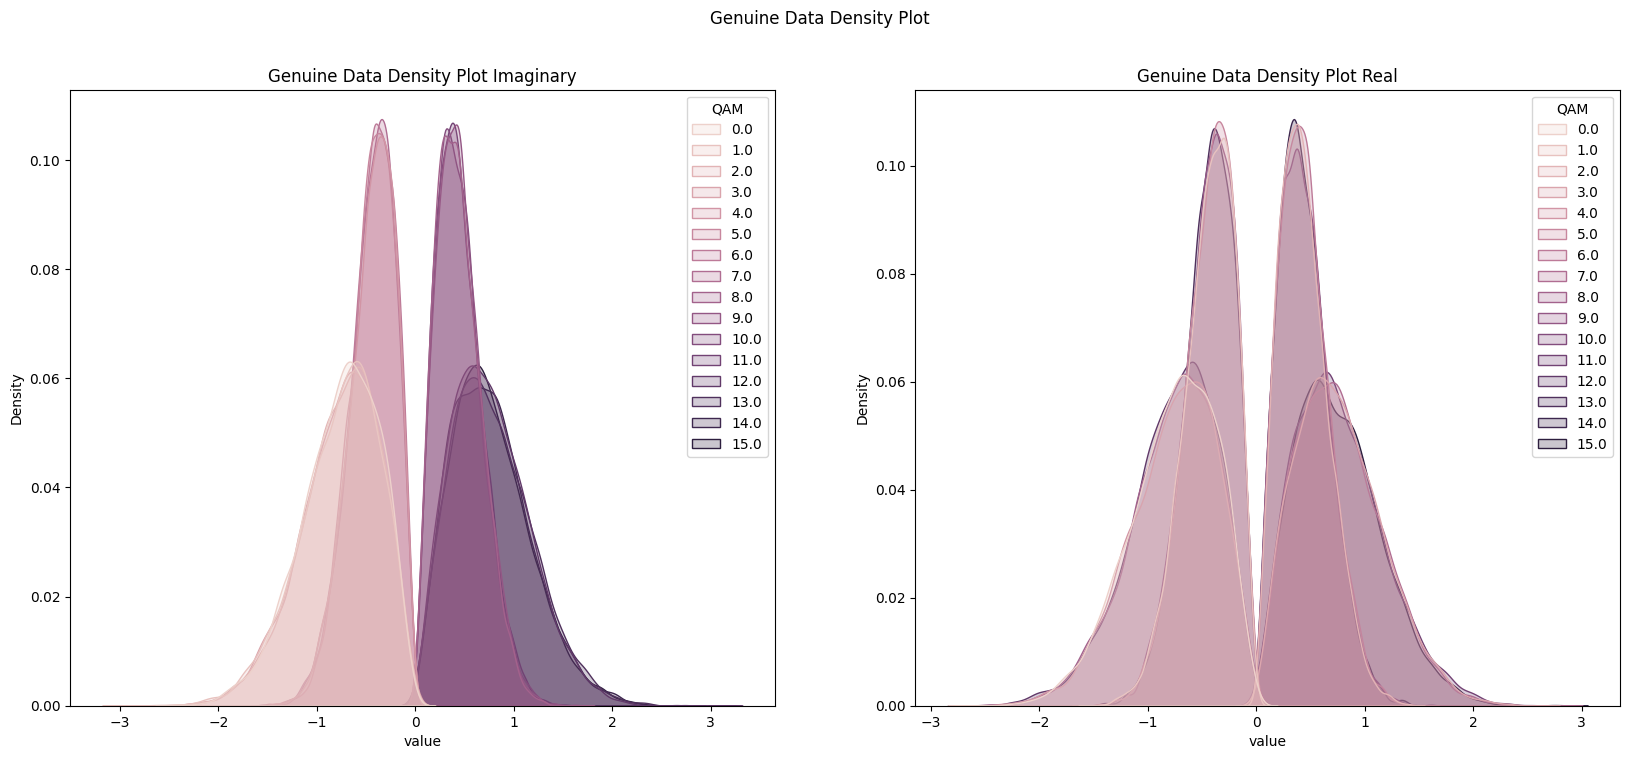

In [25]:

# Melt the data to long-form
data_melted_actual_imaginary = pd.melt(df_genuine_eval, id_vars=['QAM'], value_vars=['real'])
data_melted_actual_real = pd.melt(df_genuine_eval, id_vars=['QAM'], value_vars=['imaginary'])
# Plot the density plot


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.kdeplot(data=data_melted_actual_imaginary, x='value', hue='QAM', fill=True, ax=ax1)
ax1.set_title("Genuine Data Density Plot Imaginary")

sns.kdeplot(data=data_melted_actual_real, x='value', hue='QAM', fill=True, ax=ax2)
ax2.set_title("Genuine Data Density Plot Real")

fig.suptitle("Genuine Data Density Plot")
plt.show()

### Generated Data

In [26]:
conditional_distribution_index_value = model_eval_git.get_conditional_distribution_index_value(loaded_model, nakagami_condition, nakagami_indices)
conditional_distribution_index_value = conditional_distribution_index_value[:, :3]

 147/3125 [>.............................] - ETA: 3s

2023-12-10 01:54:13.393892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3125/3125 [==============================] - 3s 1ms/step


In [27]:
df_generated_eval = pd.DataFrame(conditional_distribution_index_value.numpy(), columns=['real', 'imaginary', 'QAM'])
df_generated_eval

,real,imaginary,QAM
0,-0.445629,0.642668,7.0
1,0.458717,0.284205,10.0
2,0.721352,-0.233320,8.0
3,-0.419719,-0.490814,4.0
4,-0.393568,1.189602,3.0
...,...,...,...
99995,0.767938,0.519356,10.0
99996,-0.284845,-0.434681,4.0
99997,0.828815,-0.815710,13.0
99998,0.531070,1.985329,11.0


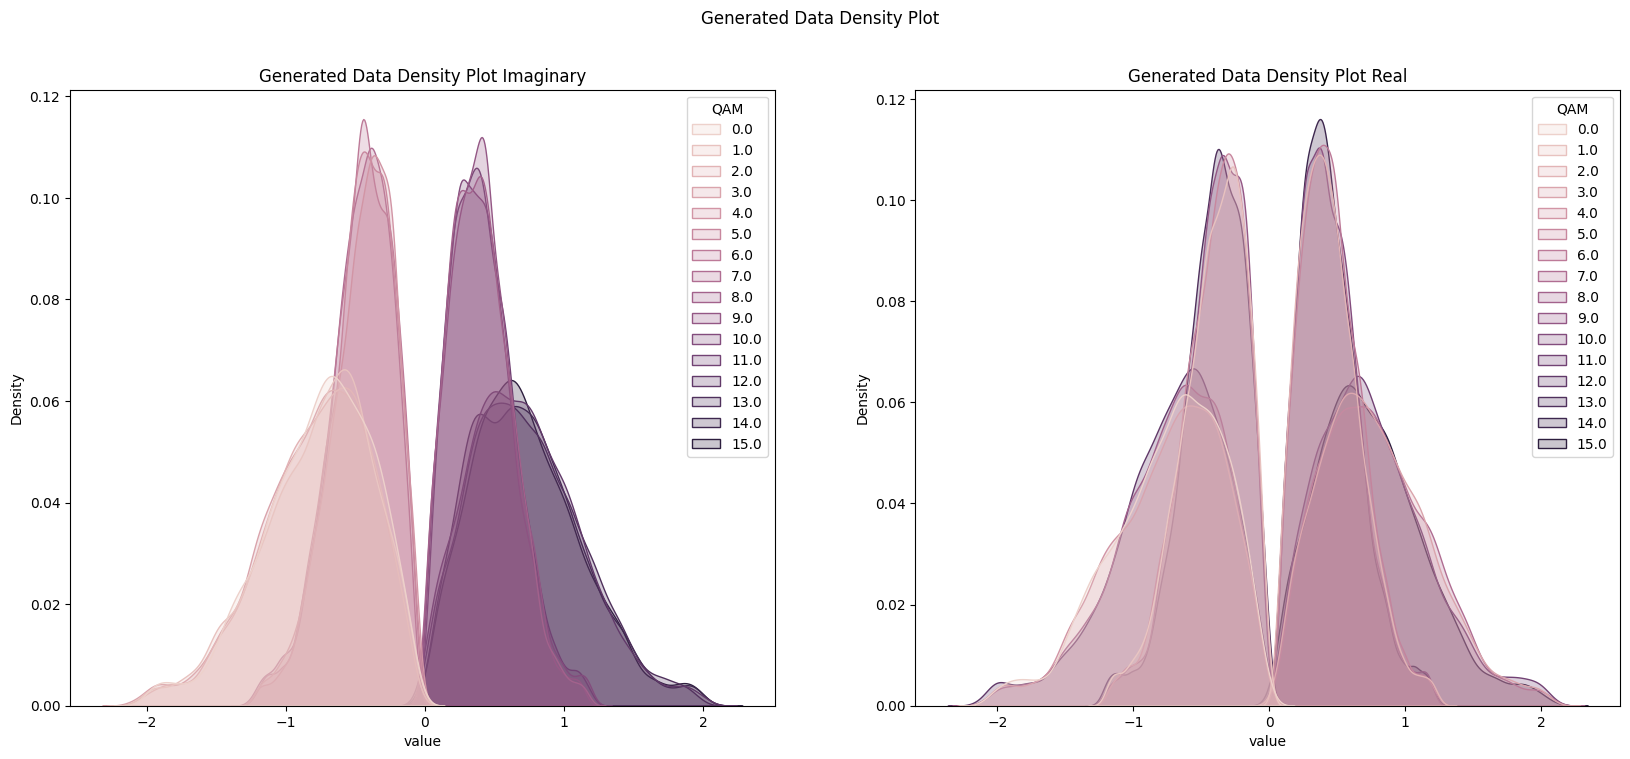

In [28]:
# Melt the data to long-form
data_melted_generated_imaginary = pd.melt(df_generated_eval, id_vars=['QAM'], value_vars=['real'])
data_melted_generated_real = pd.melt(df_generated_eval, id_vars=['QAM'], value_vars=['imaginary'])

# Plot the density plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.kdeplot(data=data_melted_generated_imaginary, x='value', hue='QAM', fill=True, ax=ax1)
ax1.set_title("Generated Data Density Plot Imaginary")

sns.kdeplot(data=data_melted_generated_real, x='value', hue='QAM', fill=True, ax=ax2)
ax2.set_title("Generated Data Density Plot Real")

fig.suptitle("Generated Data Density Plot")
plt.show()

### Overlapped Area

In [29]:
# Melt the data to long-form
data_melted_generated_imaginary = pd.melt(df_generated_eval, id_vars=['QAM'], value_vars=['real'])
data_melted_generated_real = pd.melt(df_generated_eval, id_vars=['QAM'], value_vars=['imaginary'])

# Melt the data to long-form
data_melted_actual_imaginary = pd.melt(df_genuine_eval, id_vars=['QAM'], value_vars=['real'])
data_melted_actual_real = pd.melt(df_genuine_eval, id_vars=['QAM'], value_vars=['imaginary'])

df_afterward_real = data_melted_actual_real.copy()
df_afterward_real.rename(columns={'value':'genuine_real'}, inplace=True)
df_afterward_real['generated_real'] = data_melted_generated_real['value']
df_afterward_real.drop('variable', axis=1, inplace=True)
df_afterward_real

df_afterward_real_vertical = pd.melt(df_afterward_real, id_vars=['QAM'], value_vars=['genuine_real', 'generated_real'],
                      var_name='aux', value_name='data').sort_values(by='aux', ascending=False)

df_afterward_imaginary = data_melted_actual_imaginary.copy()
df_afterward_imaginary.rename(columns={'value':'genuine_imaginary'}, inplace=True)
df_afterward_imaginary['generated_imaginary'] = data_melted_generated_imaginary['value']
df_afterward_imaginary.drop('variable', axis=1, inplace=True)
df_afterward_imaginary

df_afterward_imaginary_vertical = pd.melt(df_afterward_imaginary, id_vars=['QAM'], value_vars=['genuine_imaginary', 'generated_imaginary'],
                      var_name='aux', value_name='data').sort_values(by='aux', ascending=False)


#### __Real__

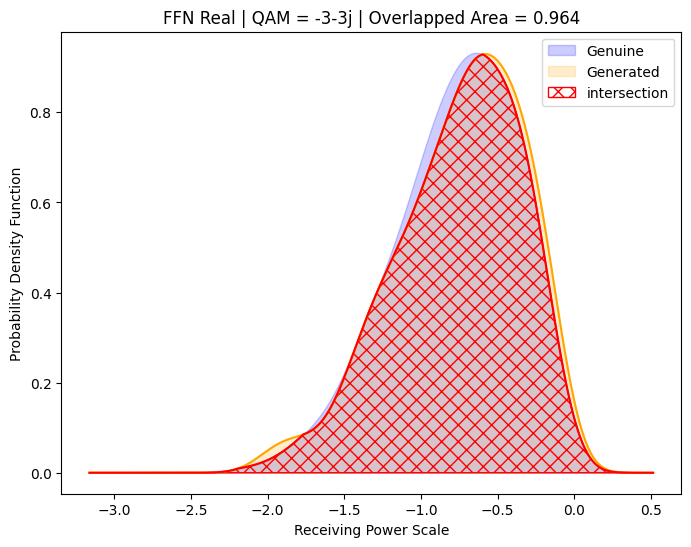

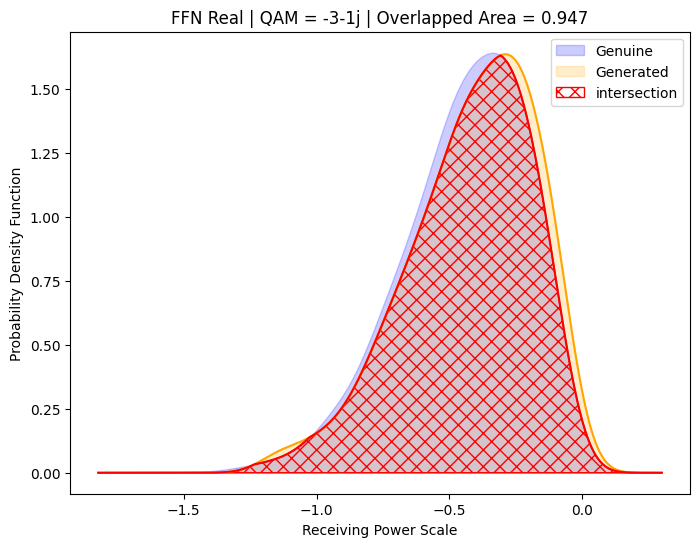

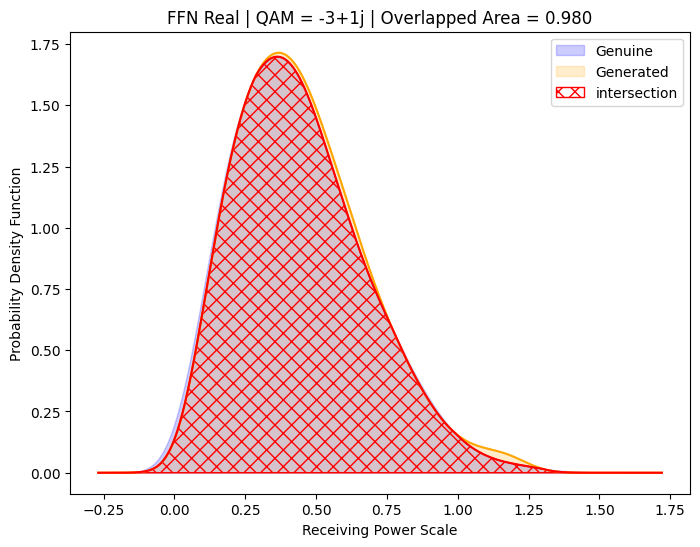

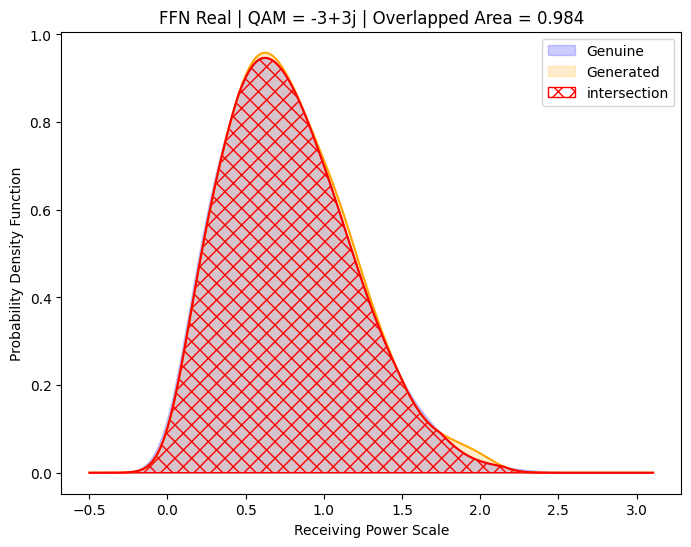

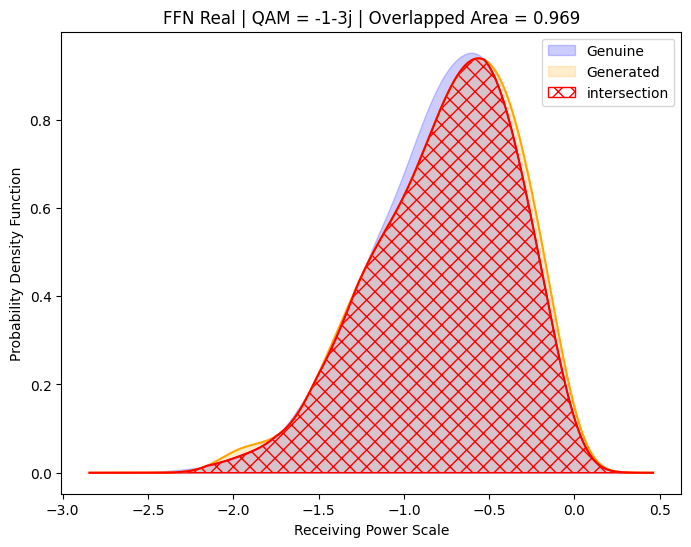

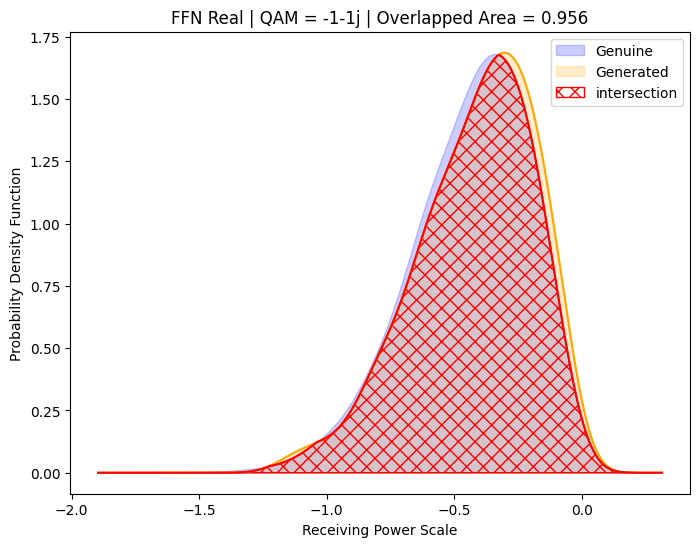

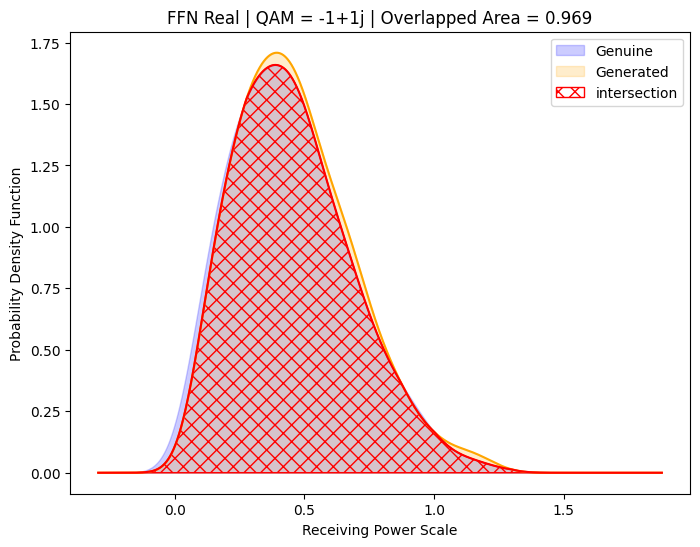

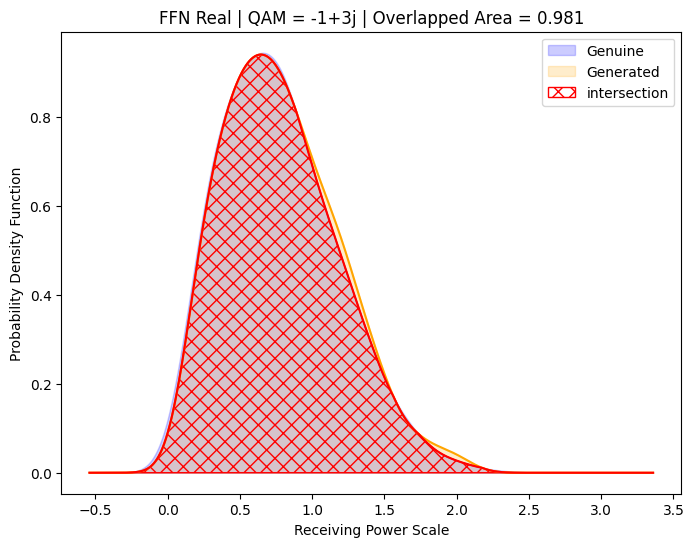

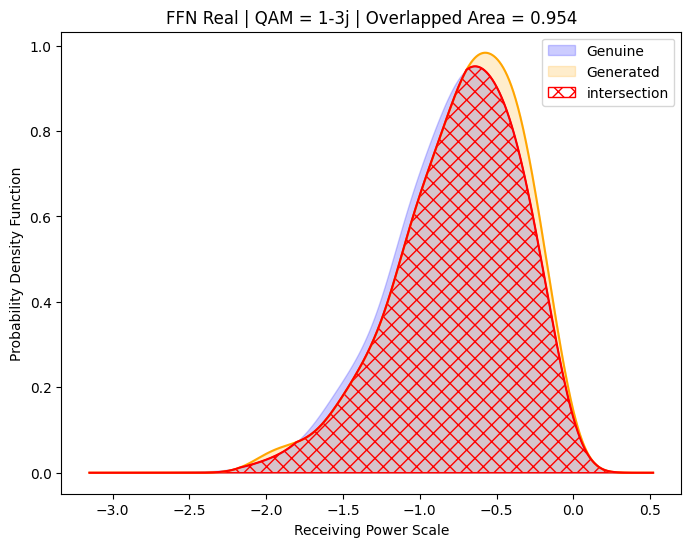

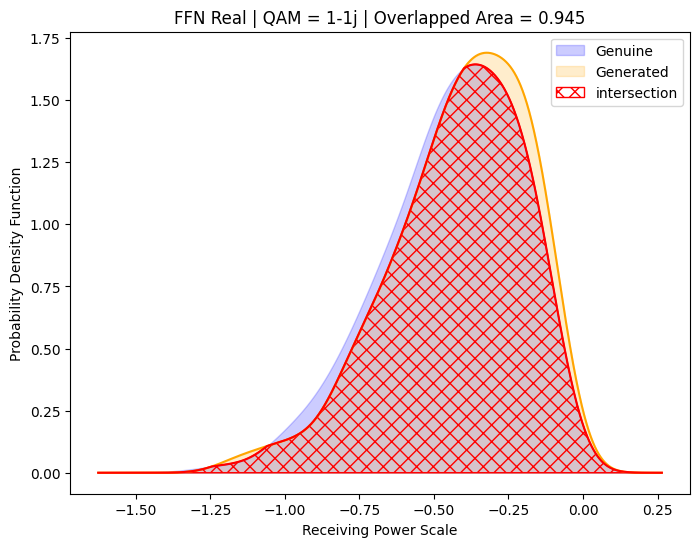

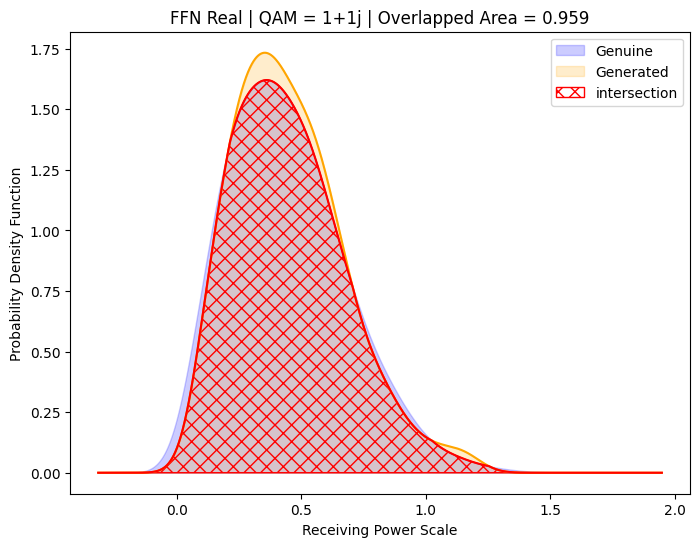

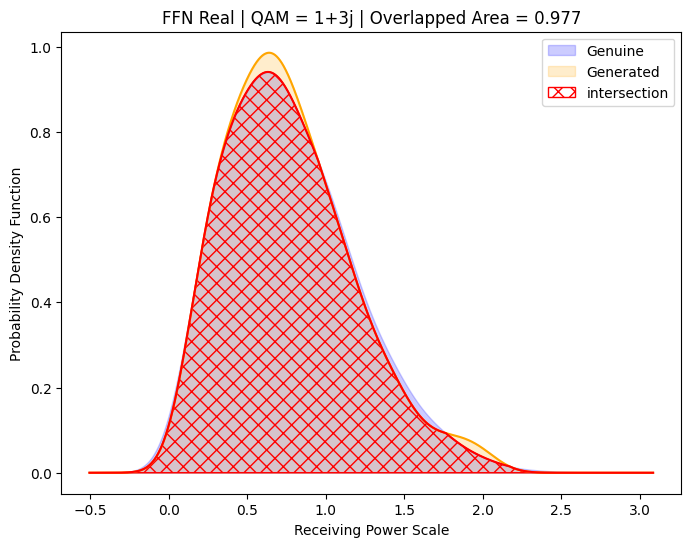

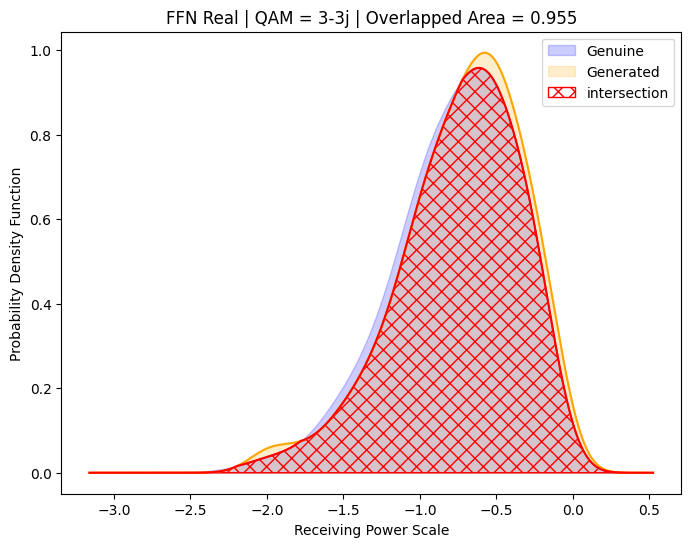

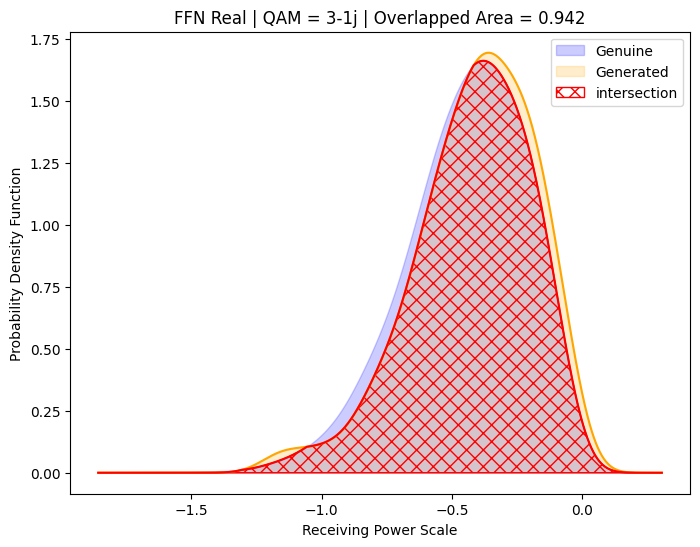

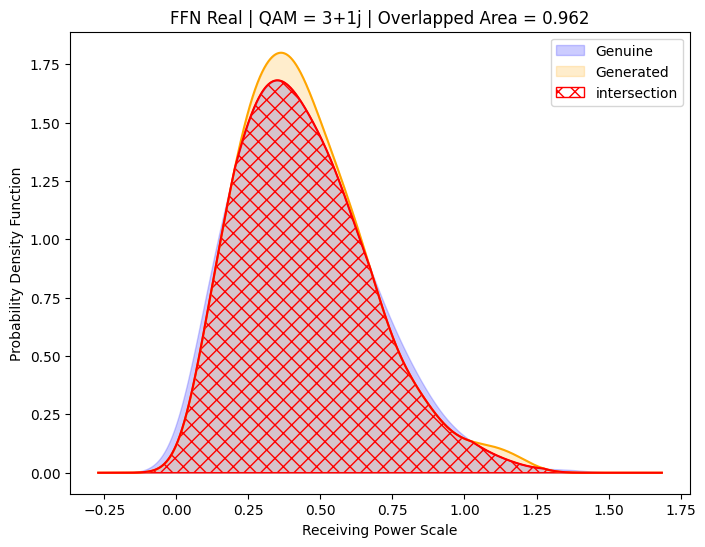

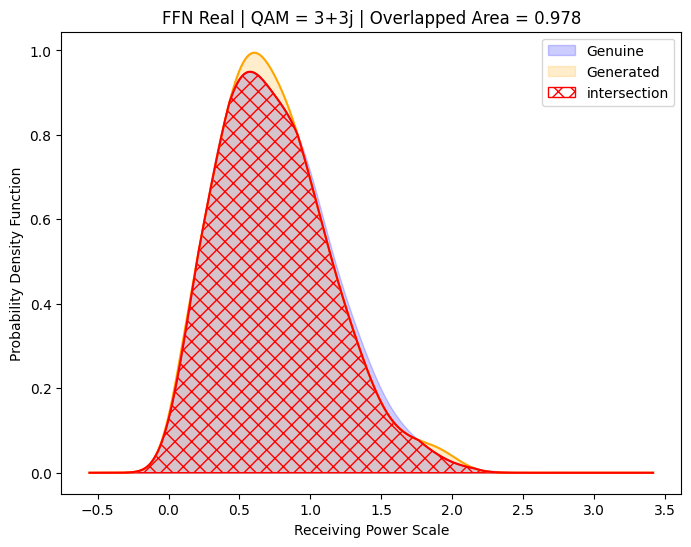

In [30]:
# https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

QAM = con.QAM
list_for_df_real = list()
for i in range(len(df_afterward_real_vertical['QAM'].unique())):

    fig, ax = plt.subplots(figsize=(8, 6))
    
    x0 = df_afterward_real[df_afterward_real['QAM'] == i]['genuine_real']
    x1 = df_afterward_real[df_afterward_real['QAM'] == i]['generated_real']

    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)
    
    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx
    
    x = np.linspace(xmin, xmax, len(x0))
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    plt.fill_between(x, kde0_x, 0, color='b', alpha=0.2, label='Genuine')
    plt.plot(x, kde1_x, color='orange')
    plt.fill_between(x, kde1_x, 0, color='orange', label='Generated', alpha=0.2)
    plt.plot(x, inters_x, color='r')
    plt.fill_between(x, inters_x, 0, facecolor='none', edgecolor='r', hatch='xx', label='intersection')
    
    area_inters_x = np.trapz(inters_x, x)
    
    list_for_df_real.append([i, area_inters_x])

    qam_img = str(int(QAM[i].imag)) if QAM[i].imag < 0 else "+" + str(int(QAM[i].imag))
    ax.set_title(f"FFN Real | QAM = {int(QAM[i].real)}{qam_img}j | Overlapped Area = {area_inters_x:.3f}")
    
    plt.xlabel('Receiving Power Scale')
    plt.ylabel('Probability Density Function')
    plt.legend()

    plt.show()


In [31]:
df_oa_real = pd.DataFrame(list_for_df_real, columns=['d', 'area_overlapped'])
print(f"Average Overlapped Area Real = {df_oa_real['area_overlapped'].mean()}")
df_oa_real

Average Overlapped Area Real = 0.9638243442058199


,d,area_overlapped
0,0,0.964226
1,1,0.946705
2,2,0.979818
3,3,0.984175
4,4,0.969149
5,5,0.956237
6,6,0.968596
7,7,0.980805
8,8,0.954443
9,9,0.944603


#### __Imaginary__

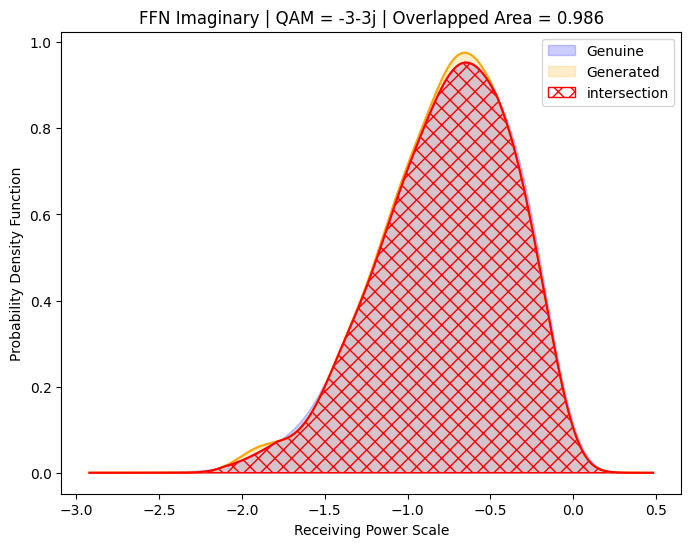

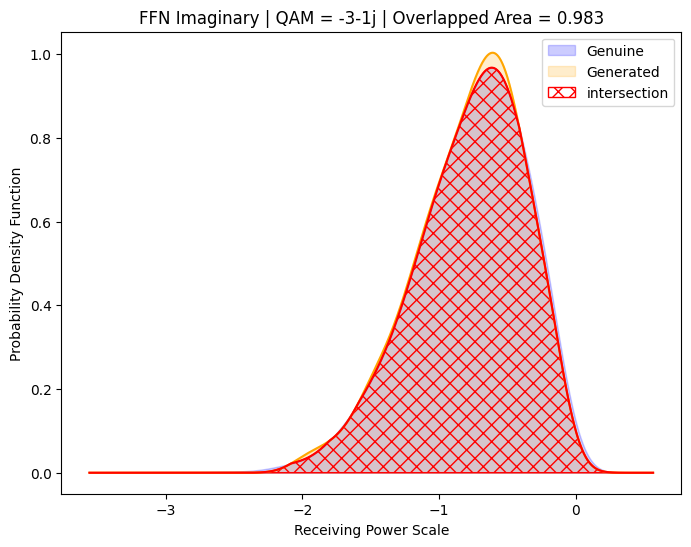

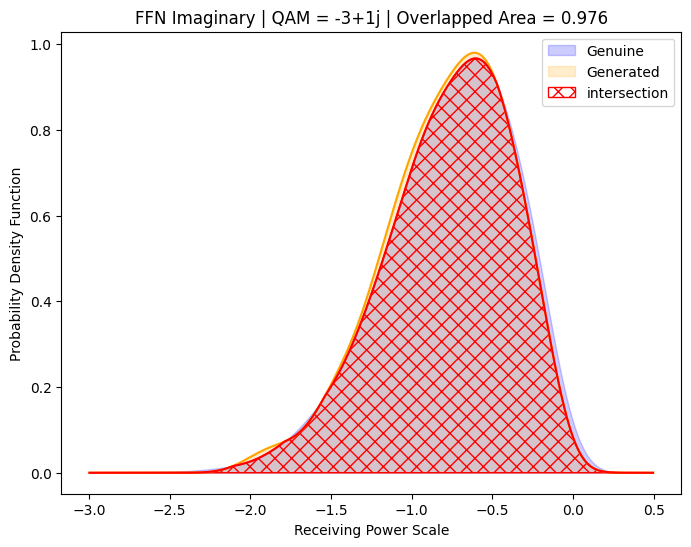

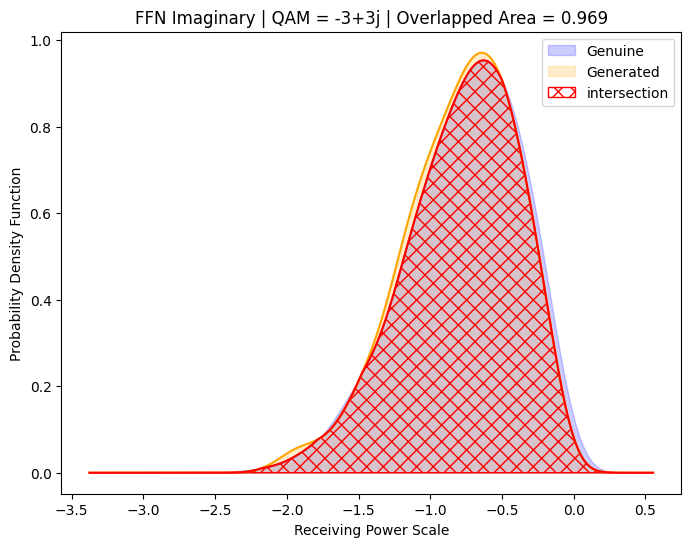

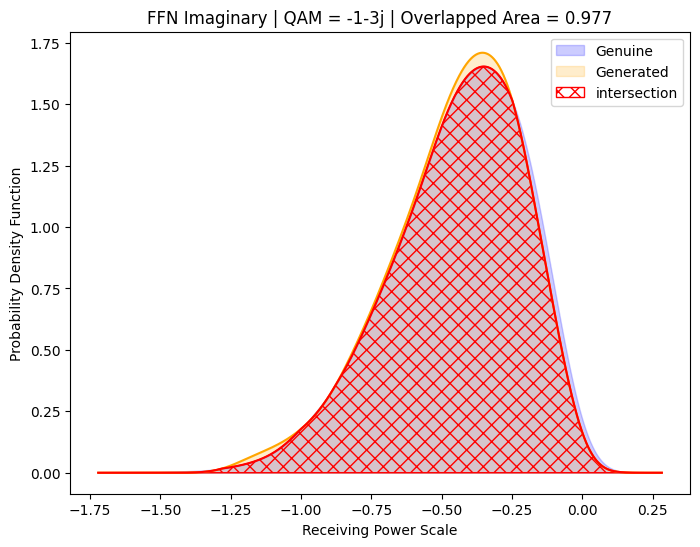

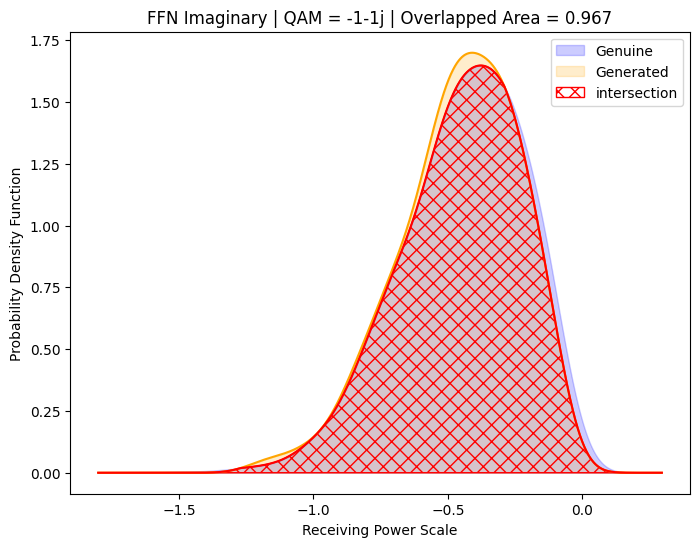

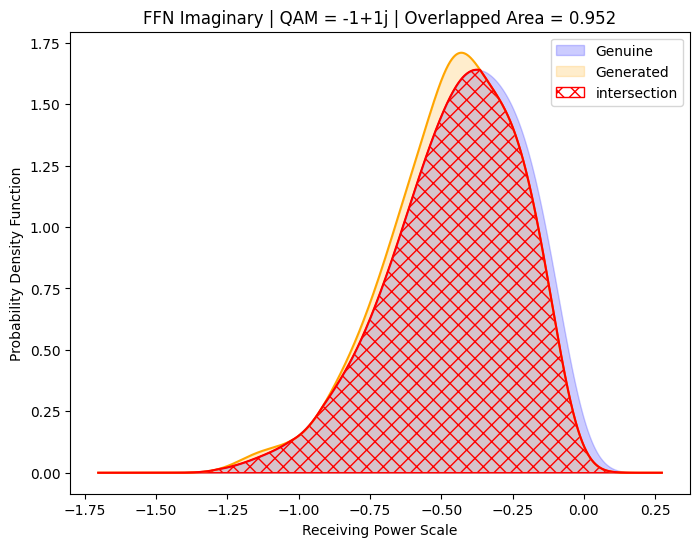

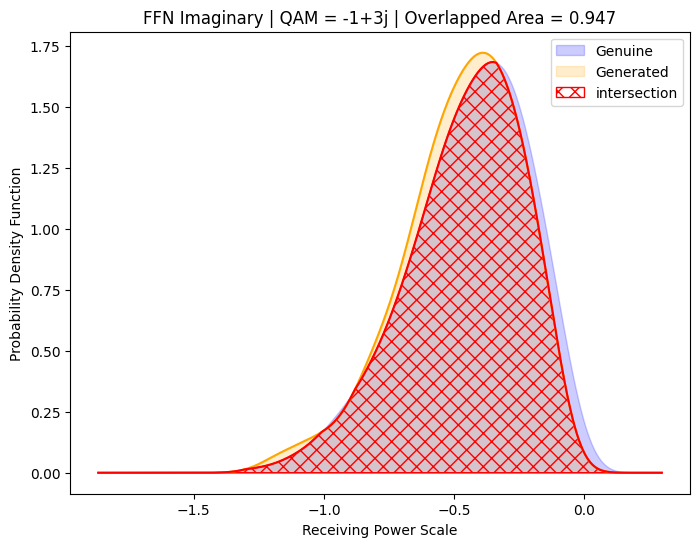

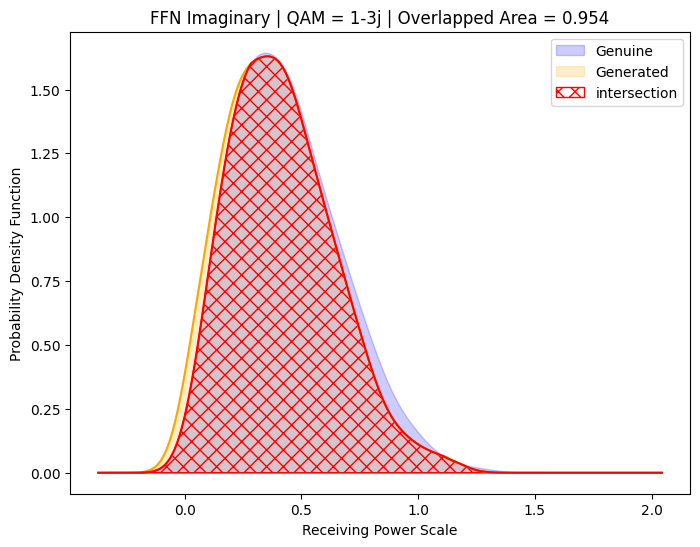

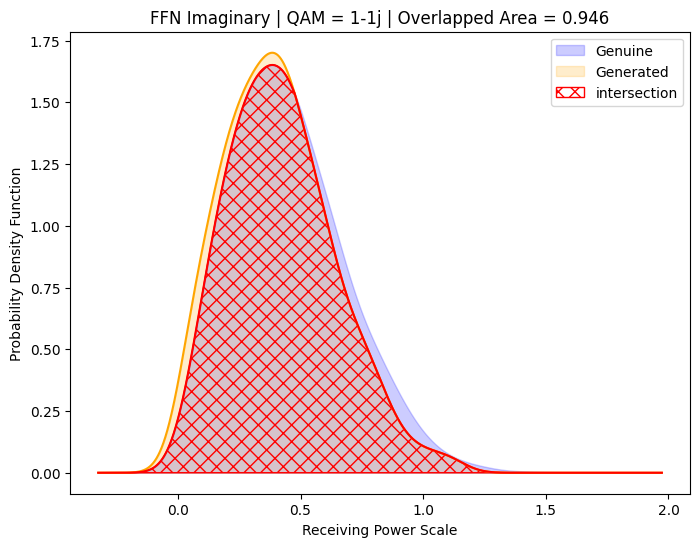

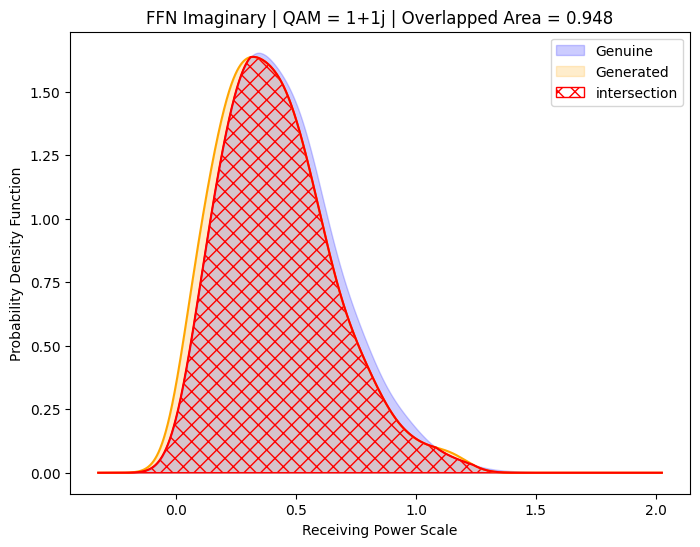

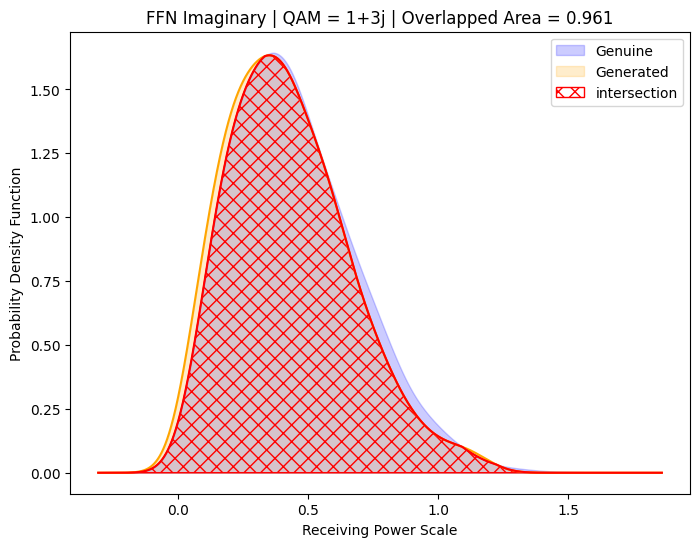

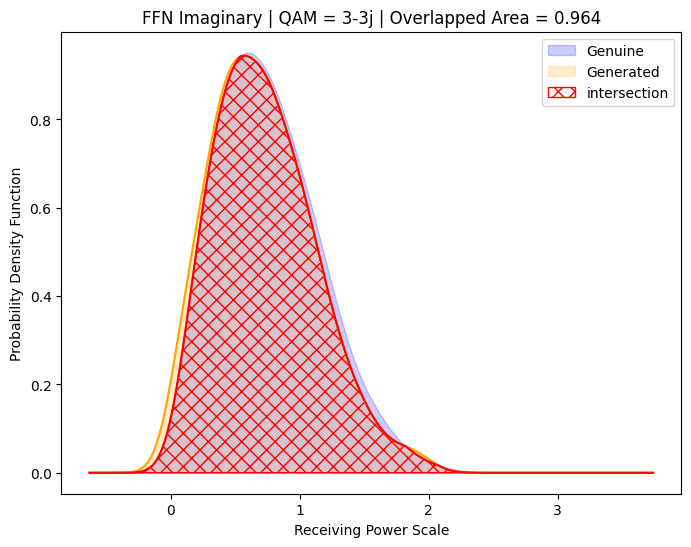

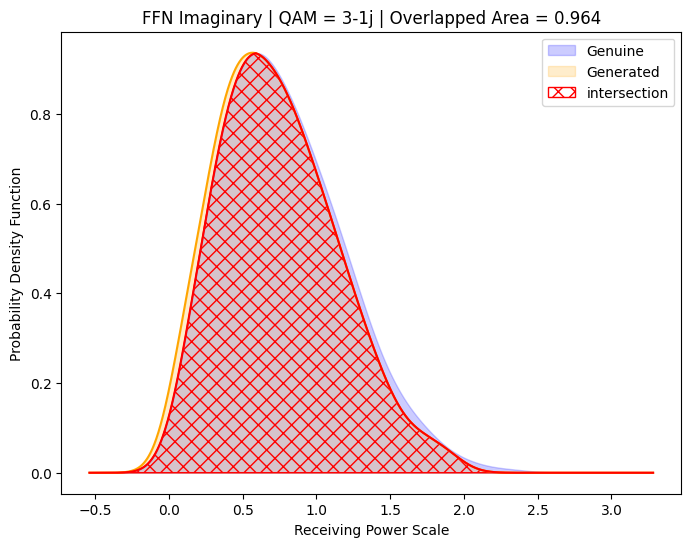

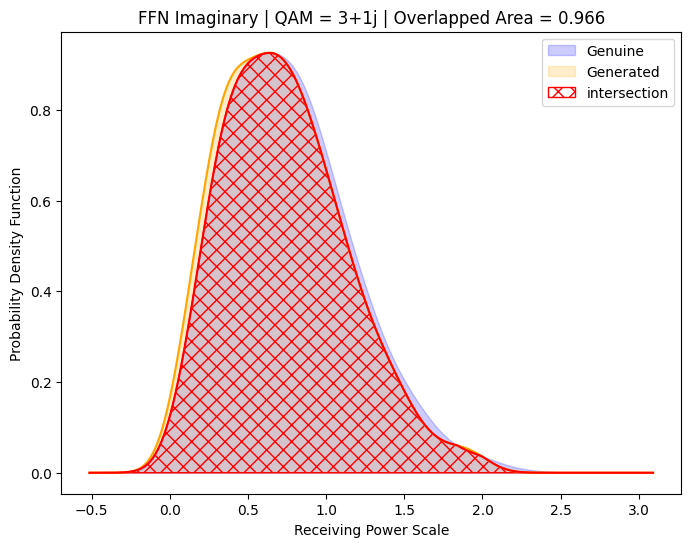

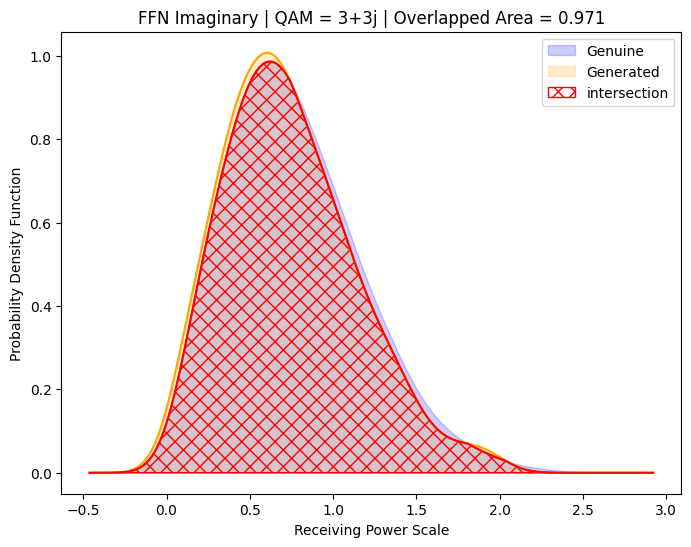

In [32]:
# https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

QAM = con.QAM
list_for_df_imag = list()
for i in range(len(df_afterward_real_vertical['QAM'].unique())):

    fig, ax = plt.subplots(figsize=(8, 6))
    
    x0 = df_afterward_imaginary[df_afterward_imaginary['QAM'] == i]['genuine_imaginary']
    x1 = df_afterward_imaginary[df_afterward_imaginary['QAM'] == i]['generated_imaginary']

    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)
    
    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx
    
    x = np.linspace(xmin, xmax, len(x0))
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    plt.fill_between(x, kde0_x, 0, color='b', alpha=0.2, label='Genuine')
    plt.plot(x, kde1_x, color='orange')
    plt.fill_between(x, kde1_x, 0, color='orange', label='Generated', alpha=0.2)
    plt.plot(x, inters_x, color='r')
    plt.fill_between(x, inters_x, 0, facecolor='none', edgecolor='r', hatch='xx', label='intersection')
    
    area_inters_x = np.trapz(inters_x, x)
    
    list_for_df_imag.append([i, area_inters_x])

    qam_img = str(int(QAM[i].imag)) if QAM[i].imag < 0 else "+" + str(int(QAM[i].imag))
    ax.set_title(f"FFN Imaginary | QAM = {int(QAM[i].real)}{qam_img}j | Overlapped Area = {area_inters_x:.3f}")
    
    plt.xlabel('Receiving Power Scale')
    plt.ylabel('Probability Density Function')
    plt.legend()

    plt.show()


In [33]:
df_oa_imag = pd.DataFrame(list_for_df_imag, columns=['d', 'area_overlapped'])
print(f"Average Overlapped Area Imaginary = {df_oa_imag['area_overlapped'].mean()}")
df_oa_imag

Average Overlapped Area Imaginary = 0.9644794356846577


,d,area_overlapped
0,0,0.986463
1,1,0.983272
2,2,0.975571
3,3,0.968564
4,4,0.976643
5,5,0.967493
6,6,0.952427
7,7,0.946564
8,8,0.954472
9,9,0.945781


### Constellation

1/1 [==============================] - 0s 24ms/step


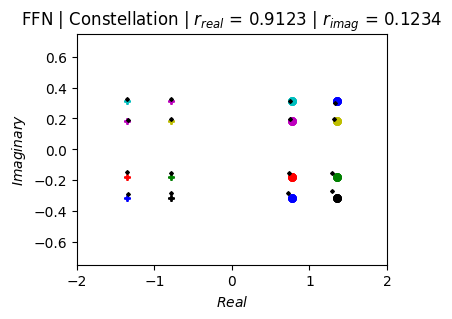

<Figure size 640x480 with 0 Axes>

In [34]:
colors = ['b+', 'r+', 'm+', 'c+', 'k+', 'g+', 'y+', 'm+', \
        'bo', 'ro', 'mo', 'co', 'ko', 'go', 'yo', 'bo']
QAM = con.QAM
m = con.m
eta = con.eta
alpha = con.alpha
d = con.d
d_0 = con.d_0

samples = np.array([])
for channel_idx in range(1):
    number = 10  #
    r_real = np.array([0.9123]) 
    r_imaginary = np.array([0.1234]) 
    r_real = np.tile(r_real, number)
    r_imaginary = np.tile(r_imaginary, number)
    
    fig, ax = plt.subplots(figsize=(4, 3))
    
    for idx in range(len(QAM)):
        labels_index = np.tile(idx, number)
        Pt = QAM[labels_index]
        
        RHS_real = gammaincinv(m, gamma(m)*r_real) / m
        RHS_imaginary = gammaincinv(m, gamma(m)*r_imaginary) / m

        Pr_d = Pt * eta * np.power((d_0/d), alpha)
        
        data_real = np.real(Pr_d) * RHS_real
        data_imaginary = np.imag(Pr_d) * RHS_imaginary
        
        sign_data_real = con.sign_checker_array(data_real)
        sign_data_imaginary = con.sign_checker_array(data_imaginary)

        # data_real(imaginary)_sign is -1 (if negative) 0 (if zero) 1 (if positive)
        # because np.sqrt(negative_number) is impossible in numpy
        nakagami_real = sign_data_real * np.sqrt(abs(data_real))
        nakagami_imaginary = sign_data_imaginary * np.sqrt(abs(data_imaginary))

        transmit_data = np.hstack((nakagami_real.reshape(len(Pt), 1),
                                nakagami_imaginary.reshape(len(Pt), 1)))
        
        conditioning = np.hstack(
            (np.real(Pt).reshape(len(Pt), 1)/3, np.imag(Pt).reshape(len(Pt), 1)/3,
            r_real.reshape(len(Pt), 1), r_imaginary.reshape(len(Pt), 1)))
        
        samples_component = loaded_model.predict([conditioning])

        plt.plot(transmit_data[:, 0], transmit_data[:, 1], colors[idx], markersize=5)
        plt.plot(samples_component[:, 0], samples_component[:, 1], 'k.', markersize=3)
  
    plt.title(f"FFN | Constellation | $r_{{real}}$ = {r_real[0]} | $r_{{imag}}$ = {r_imaginary[0]}")
    
    axes = plt.gca()
    axes.set_xlim([-2., 2.])
    axes.set_ylim([-0.75, 0.75])
    xlabel = r'$Real$'
    ylabel = r'$Imaginary$'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.show()

plt.clf()



### Generated Data Evalulation

#### Mean

In [35]:
df_mean_comp = pd.concat([df_generated_eval.groupby('QAM').mean(), df_ideal_mean], axis=1)
df_per_diff_mean_real = (((df_mean_comp['real'] - df_mean_comp['ideal_real']) / df_mean_comp['ideal_real']) * 100).round(2)
df_per_diff_mean_imaginary = (((df_mean_comp['imaginary'] - df_mean_comp['ideal_imaginary']) / df_mean_comp['ideal_imaginary']) * 100).round(2)
df_per_diff_mean_dict = {'per_diff_real_%':df_per_diff_mean_real, 'per_diff_imaginary_%':df_per_diff_mean_imaginary}
df_mean_comp_final = pd.concat([df_mean_comp, pd.DataFrame(df_per_diff_mean_dict)], axis=1)
df_mean_comp_final[df_mean_comp_final.columns[[0, 2, 4, 1, 3, 5]]]

,real,ideal_real,per_diff_real_%,imaginary,ideal_imaginary,per_diff_imaginary_%
0.0,-0.770178,-0.767495,0.35,-0.751211,-0.767495,-2.12
1.0,-0.778626,-0.767495,1.45,-0.417422,-0.443113,-5.80
2.0,-0.781905,-0.767495,1.88,0.451309,0.443113,1.85
3.0,-0.792683,-0.767495,3.28,0.781877,0.767495,1.87
4.0,-0.452386,-0.443113,2.09,-0.757608,-0.767495,-1.29
5.0,-0.458537,-0.443113,3.48,-0.418305,-0.443113,-5.60
6.0,-0.461890,-0.443113,4.24,0.464367,0.443113,4.80
7.0,-0.471066,-0.443113,6.31,0.786849,0.767495,2.52
8.0,0.404919,0.443113,-8.62,-0.733417,-0.767495,-4.44
9.0,0.410480,0.443113,-7.36,-0.414271,-0.443113,-6.51


#### Variance

In [36]:
df_var_comp = pd.concat([df_generated_eval.groupby('QAM').var(), df_ideal_var], axis=1)
df_per_diff_var_real = (((df_var_comp['real'] - df_var_comp['ideal_real']) / df_var_comp['ideal_real']) * 100).round(2)
df_per_diff_var_imaginary = (((df_var_comp['imaginary'] - df_var_comp['ideal_imaginary']) / df_var_comp['ideal_imaginary']) * 100).round(2)
df_per_diff_var_dict = {'per_diff_real_%':df_per_diff_var_real, 'per_diff_imaginary_%':df_per_diff_var_imaginary}
df_var_comp_final = pd.concat([df_var_comp, pd.DataFrame(df_per_diff_var_dict)], axis=1)
df_var_comp_final[df_var_comp_final.columns[[0, 2, 4, 1, 3, 5]]]

,real,ideal_real,per_diff_real_%,imaginary,ideal_imaginary,per_diff_imaginary_%
0.0,0.152708,0.160951,-5.12,0.172923,0.160951,7.44
1.0,0.156952,0.160951,-2.48,0.057148,0.053650,6.52
2.0,0.149059,0.160951,-7.39,0.052263,0.053650,-2.59
3.0,0.153806,0.160951,-4.44,0.159255,0.160951,-1.05
4.0,0.053489,0.053650,-0.30,0.171138,0.160951,6.33
5.0,0.049883,0.053650,-7.02,0.054492,0.053650,1.57
6.0,0.050288,0.053650,-6.27,0.051382,0.053650,-4.23
7.0,0.050612,0.053650,-5.66,0.157848,0.160951,-1.93
8.0,0.051497,0.053650,-4.01,0.160592,0.160951,-0.22
9.0,0.050276,0.053650,-6.29,0.052454,0.053650,-2.23
